Confusion Matrix:
[[12786   295]
 [  668  1944]]
Classification Report:
             precision    recall  f1-score   support

          0       0.95      0.98      0.96     13081
          1       0.87      0.74      0.80      2612

avg / total       0.94      0.94      0.94     15693

ROC_AUC_SCORE is 0.860852740721524


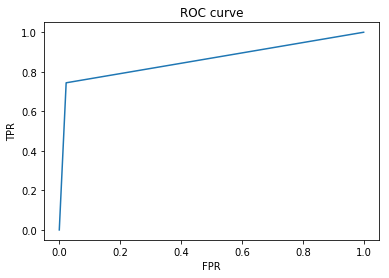

score is: 0.8682447521214828
0    19256
1     3165
Name: Claim, dtype: int64


In [2]:
#importing reqired libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score ,mean_squared_error,accuracy_score,classification_report,confusion_matrix,roc_curve
import warnings
warnings.filterwarnings('ignore')

data=pd.read_csv('train.csv')

#removing ID column
data.drop(columns=['ID'],axis=1,inplace=True)
data.head()

#checking for class imbalance 
def class_imbalance(target):
    class_values = (target.value_counts()/target.value_counts().sum())*100
    return class_values
class_imbalance(data['Claim'])


#label encoding the data
le = LabelEncoder()
# Function that auto encodes any dataframe column of type category or object.
def dummyEncode(dataset):
        
        columnsToEncode = list(dataset.select_dtypes(include=['category','object']))
        le = LabelEncoder()
        for feature in columnsToEncode:
            try:
                dataset[feature] = le.fit_transform(dataset[feature])
            except:
                print('Error encoding '+feature)
        return dataset
data = dummyEncode(data)

#predictors for training
X = data.iloc[:,:-1]

# Target
y = data.iloc[:,-1]


def XGboost(dataframe,target):
    
    x_train,x_val,y_train,y_val = train_test_split(dataframe,target, test_size=0.3, random_state=42)

    global xgbc
    rfc_clf=RandomForestClassifier()
    xgbc = XGBClassifier(base_estimator=rfc_clf,random_state=42,learning_rate=0.7,gamma=0.7,max_depth=8,min_child_weight=5,scale_pos_weight=0.7)
    xgbc.fit(x_train, y_train)
    y_pred=xgbc.predict(x_val)
    precision=precision_score(y_val,y_pred)
    print('Confusion Matrix:')
    print(confusion_matrix(y_val,y_pred))  
    print('Classification Report:')
    print(classification_report(y_val,y_pred))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_pred)
    print('ROC_AUC_SCORE is',roc_auc_score(y_val, y_pred))
    plt.plot(false_positive_rate, true_positive_rate)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()
    return precision

#trainning
precision = XGboost(X,y)    
print('score is:',precision)

#testing function
def prediction(test):
    y_pred = xgbc.predict(test)
    
    return y_pred

test=pd.read_csv('test.csv')

# Storing the Id column
Id = test[['ID']]

# Preprocessed Test File
test.drop('ID',1,inplace=True)
test.head()
#label encoder
test = dummyEncode(test)
test.head()

#predicting on test file
y_pred = pd.DataFrame(prediction(test),columns=['Claim']) 
print(y_pred['Claim'].value_counts())
submission = pd.concat([Id,y_pred['Claim']],1)
submission.to_csv('submission.csv',index=False)